In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats
# import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
# from matplotlib import style
# style.use('ggplot') or plt.style.use('ggplot')
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Loading Matrix Distances

In [2]:
matrix = pd.read_csv("NoWaterNodes_Distances.csv", sep=";", index_col=0)
matrix.head()

,police_distance,hospital_distance,bank_distance,casino_distance,courthouse_distance,school_distance,university_distance,marketplace_distance
osmid,,,,,,,,
914290204,2.476109,3.589257,7.518962,12.074351,7.612450,0.698371,3.778315,2.416770
1572591430,3.856053,1.960662,5.890367,10.445756,7.204732,0.496094,4.645025,3.728522
1757617874,3.326836,3.431502,7.361207,11.916596,8.463177,1.549098,4.629042,3.267497
2886418954,4.496008,4.693962,8.623667,13.179056,9.938032,1.413258,7.378325,4.285310
3718988215,5.109873,4.080097,8.009802,12.565191,9.324167,2.027123,6.764460,4.899175


In [432]:
matrix.shape

(6403, 11)

In [445]:
tmp = matrix.head(5).reset_index()
tmp.drop(['kmeans', 'hc', 'optics', 'casino_distance'], inplace=True, axis=1)
tmp['latex'] = tmp.apply(lambda x: '&'.join(round(x,2).map(str)), axis=1)
tmp
[x for x in tmp['latex']]

['914290204.0&2.48&3.59&7.52&7.61&0.7&3.78&2.42',
 '1572591430.0&3.86&1.96&5.89&7.2&0.5&4.65&3.73',
 '1757617874.0&3.33&3.43&7.36&8.46&1.55&4.63&3.27',
 '2886418954.0&4.5&4.69&8.62&9.94&1.41&7.38&4.29',
 '3718988215.0&5.11&4.08&8.01&9.32&2.03&6.76&4.9']

# PCA

In [214]:
%%time
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================

features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# train = matrix

pca_pipe = make_pipeline(MinMaxScaler(), PCA())
# pca_pipe = make_pipeline(PCA())
pca_pipe.fit(train)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

CPU times: user 29.1 ms, sys: 7.17 ms, total: 36.3 ms
Wall time: 7.62 ms


In [215]:
%%time
# Se combierte el array a dataframe para añadir nombres a los ejes.

index = ['PC{}'.format(i+1) for i in range(modelo_pca.components_.shape[1])]

pcaDF = pd.DataFrame(
    data    = np.round(modelo_pca.components_,2),
    columns = train.columns,
    index   = index
)
pcaDF

CPU times: user 415 µs, sys: 0 ns, total: 415 µs
Wall time: 428 µs


,police_distance,hospital_distance,bank_distance,courthouse_distance,school_distance,university_distance,marketplace_distance
PC1,0.20,0.71,0.25,0.36,0.18,0.37,0.30
PC2,0.29,-0.67,0.32,0.14,0.16,0.31,0.46
PC3,0.08,0.15,-0.38,-0.67,0.32,0.01,0.52
PC4,0.15,0.02,0.08,0.30,0.42,-0.82,0.19
PC5,0.04,0.06,-0.13,0.13,-0.79,-0.23,0.54
PC6,-0.19,-0.14,-0.76,0.53,0.19,0.20,0.08
PC7,0.90,0.01,-0.29,-0.01,-0.11,0.00,-0.30


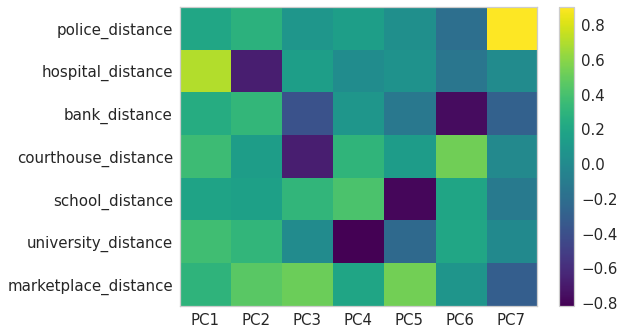

In [216]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1)
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(train.columns)), train.columns)
# plt.yticks(rotation=45)

# plt.xticks(range(len(train.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.xticks(range(len(train.columns)), index)
# plt.yticks(range(len(train.columns)), ['Client age', 'Trips', 'Spending', 'Merchants'])

plt.grid(False)
ax.set_title('Principal Componet Analysis (PCA)')
ax.tick_params(axis='both', which='major', labelsize='15')
ax.set_title("")
cb = plt.colorbar()
cb.ax.tick_params(labelsize='15')

----------------------------------------------------
Variance explained by each componet
----------------------------------------------------
[0.58414386 0.17129938 0.10096446 0.06025295 0.03800419 0.03298492
 0.01235025]


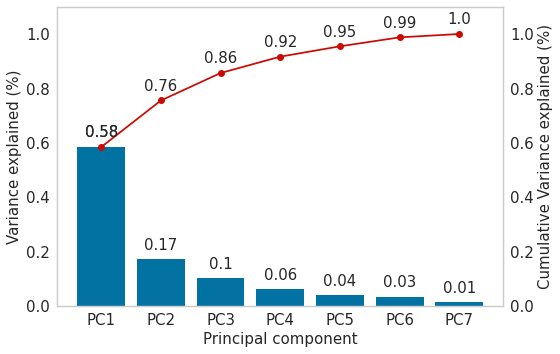

In [217]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Variance explained by each componet')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)
plt.rcParams.update({'font.size': 15})

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True)
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(train.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax2 = ax.twinx()

prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()

ax2.plot(
    np.arange(len(train.columns)) + 1,
    prop_varianza_acum,
    marker = 'o',
    color='r'
)

for x, y in zip(np.arange(len(train.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax2.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
index = ['PC{}'.format(i+1) for i in range(modelo_pca.components_.shape[1])]
# ax.set_xticks(range(1,len(train.columns)+1), index)
plt.xticks(range(1,len(train.columns)+1), index)

ax.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
ax.grid(False)


ax.set_title('')
ax.set_xlabel('Principal component', fontsize=15)
ax.set_ylabel('Variance explained (%)', fontsize=15);
ax2.set_ylabel('Cumulative Variance explained (%)', fontsize=15);
ax.tick_params(axis='both', which='major', labelsize='15')
ax2.tick_params(axis='both', which='major', labelsize='15')

ax2.grid(False)
plt.show()

# Loading LimaNodes and Lima Map

In [188]:
%%time
##Loading Nodes and Lima Map
import geopandas as gpd
limanodes = pd.read_csv("LimaOSM/LimaNodes.csv", index_col=0)
gs = gpd.GeoSeries.from_wkt(limanodes['geometry'])
limanodes = gpd.GeoDataFrame(limanodes, geometry=gs)

limaMapa = gpd.read_file("../Turismo/shapes/peru.shp")

CPU times: user 2.33 s, sys: 96.9 ms, total: 2.43 s
Wall time: 2.5 s


In [191]:
limaMapa.head()

,iddpto,departamen,idprov,provincia,iddist,distrito,capital,codccpp,area,fuente,geometry
0,01,AMAZONAS,0101,CHACHAPOYAS,010103,BALSAS,BALSAS,0001,1,INEI,"POLYGON ((-77.93289 -6.69210, -77.92945 -6.692..."
1,01,AMAZONAS,0105,LUYA,010515,PROVIDENCIA,PROVIDENCIA,0001,1,INEI,"POLYGON ((-78.29830 -6.27144, -78.29813 -6.271..."
2,01,AMAZONAS,0105,LUYA,010504,COLCAMAR,COLCAMAR,0001,1,INEI,"POLYGON ((-78.03590 -6.27044, -78.03246 -6.270..."
3,01,AMAZONAS,0106,RODRIGUEZ DE MENDOZA,010603,COCHAMAL,COCHAMAL,0001,1,INEI,"POLYGON ((-77.61592 -6.32152, -77.61650 -6.322..."
4,01,AMAZONAS,0105,LUYA,010514,PISUQUIA,YOMBLON,0001,1,INEI,"POLYGON ((-78.04105 -6.39687, -78.04115 -6.397..."


<AxesSubplot:>

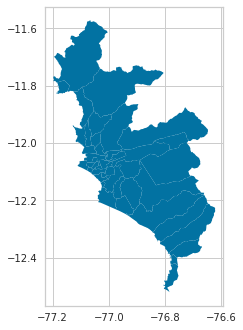

In [192]:
limaMapa[limaMapa.provincia=='LIMA'].plot()

# k-Means

In [218]:
%%time
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import time

features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# train = matrix
# X_scaled = MinMaxScaler().fit_transform(train)
X = train

n_clusters = range(2,30)
# list(range(2,21))
results = []

for k in n_clusters:
    start = time.time()
    model = KMeans(n_clusters=k, random_state=0)
    model.fit(X)
    end = time.time()
    duration = end - start
    results.append((k, model.inertia_, duration))
    

CPU times: user 16min 31s, sys: 7min 23s, total: 23min 54s
Wall time: 41.2 s


In [219]:
resDF = pd.DataFrame(results, columns=['k', 'distorsion score', 'time']).set_index('k')
resDF.head()

,distorsion score,time
k,,
2,832333.896348,1.381960
3,690731.606465,1.411640
4,582430.282702,1.475340
5,499259.993615,1.479114
6,424021.175759,1.446892


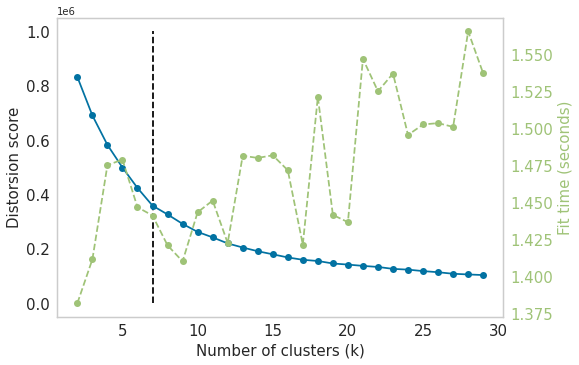

In [221]:
fig, ax = plt.subplots()

ax = resDF.plot(kind='line', y='distorsion score', ax=ax, marker='o')

ax2 = ax.twinx()
resDF.plot(kind='line', y='time', ax=ax2, color='g', marker='o', linestyle='--')
ax.vlines(x=7, ymin=0, ymax=1e6, linestyles='--', color='black')
ax.grid(False)
ax2.grid(False)

ax.tick_params(axis='both', which='major', labelsize='15')
ax2.tick_params(axis='both', which='major', labelsize='15', colors='g')
ax.set_xlabel("Number of clusters (k)", fontsize=15)
ax.set_ylabel("Distorsion score", fontsize=15)
ax2.set_ylabel("Fit time (seconds)", fontsize=15, color='g')

# ax.annotate('elbow at k=6', xy=(6, 1), xytext=(7, 1), fontsize=15, color='red',
#             arrowprops=dict(color='red', width=1.5))

ax.legend().remove()
ax2.legend().remove()

In [313]:
%%time
#k-Means
features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# X_scaled = MinMaxScaler().fit_transform(train)
X = train
#k-means
k = 7
kmeansModel = KMeans(n_clusters=k, random_state=0)
kmeansModel.fit(X)

matrix['kmeans'] = kmeansModel.labels_

CPU times: user 31.8 s, sys: 16.4 s, total: 48.2 s
Wall time: 1.43 s


In [468]:
matrix['kmeans_label'] = matrix.apply(lambda x : 'K' + str(int(x['kmeans'])), axis=1 )
matrix.head()

,police_distance,hospital_distance,bank_distance,casino_distance,courthouse_distance,school_distance,university_distance,marketplace_distance,kmeans,hc,optics,kmeans_label
osmid,,,,,,,,,,,,
914290204,2.476109,3.589257,7.518962,12.074351,7.612450,0.698371,3.778315,2.416770,0,0,-1,K0
1572591430,3.856053,1.960662,5.890367,10.445756,7.204732,0.496094,4.645025,3.728522,0,0,-1,K0
1757617874,3.326836,3.431502,7.361207,11.916596,8.463177,1.549098,4.629042,3.267497,0,0,-1,K0
2886418954,4.496008,4.693962,8.623667,13.179056,9.938032,1.413258,7.378325,4.285310,0,0,-1,K0
3718988215,5.109873,4.080097,8.009802,12.565191,9.324167,2.027123,6.764460,4.899175,0,0,-1,K0


In [322]:
# sns.histplot(data=train, x='kmeans')
tmp = matrix.groupby('kmeans').agg(['count', 'mean'])
tmp[tmp.columns[[0,1,3,5,7,9,11,13]]]
tmp[tmp.columns[[1,3,5,7,9,11,13]]].mean(axis=1)

police_distance            hospital_distance bank_distance  \
                 count       mean              mean          mean   
kmeans                                                              
0                 2935   3.212676          3.321716      4.251444   
1                 1252   4.265345          7.376114      7.197485   
2                  665   4.415231         15.193780      4.067934   
3                  137   8.734049         21.943574     22.806256   
4                  599  11.773886         11.857931     12.044437   
5                   11  67.870184          7.010302     62.445226   
6                  804   5.363852          5.280720     12.913272   

       casino_distance courthouse_distance school_distance university_distance  
                  mean                mean            mean                mean  
kmeans                                                                          
0             8.561459            8.524687        1.318854            5.543156  
1            10.997229            8.641982        2.533306           14.566637  
2            15.794160           16.615713        2.467628            7.637145  
3            40.679330           33.414098        5.185705           31.333776  
4            21.003590           16.677184        6.715587           18.604588  
5            63.820480           57.685628       23.986042           64.070003  
6             9.540130           15.994304        1.250155            5.967913

In [461]:
tmp['kmeans'].unique()

array([nan,  0.,  1.,  4.,  6.,  5.,  3.,  2.])

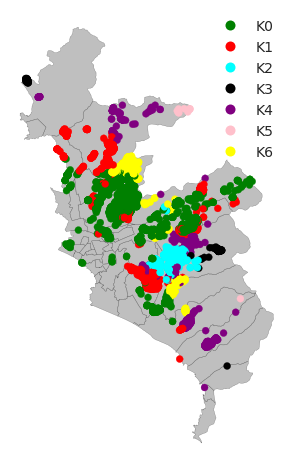

CPU times: user 2.94 s, sys: 181 ms, total: 3.12 s
Wall time: 2.87 s


In [575]:
%%time
#Ploting k-Means clustering
# import matplotlib as mpl

fig, ax = plt.subplots(figsize = (5,10))
tmp = limanodes.join(matrix['kmeans_label'])
cond = ~tmp['kmeans_label'].isna()
# tmp
limaMapa[limaMapa.provincia=='LIMA'].plot(ax=ax, color='gray', edgecolor='k', alpha=.5)


cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','yellow'])
# tmp['kmeans'] = tmp.apply(lambda x: 'c'+str(tmp.kmeans), axis=1 ) #['kmeans']
# colors = pl.cm.jet(np.linspace(0,1,6))
ax = tmp[cond].plot(column='kmeans_label', ax=ax, cmap=cmap, categorical=True, legend=True,
               legend_kwds = {'fontsize':14}
              )
# plt.colorbar(ticks=range(6), label='k-means')
# ax.legend(['0', '1', '2','3','4','5','6'])
# ax.legend(fontsize=15)
# ax.get_legend(fontsize(15))
_ = plt.axis(False)
plt.show()

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


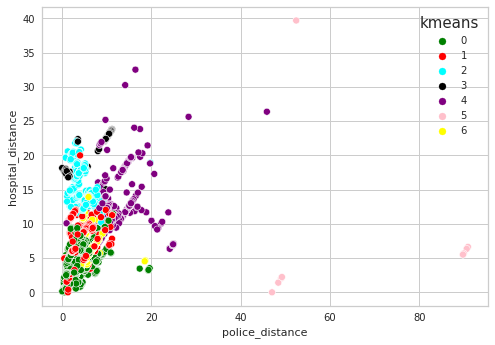

In [236]:
ax = sns.scatterplot(data=train[cond], x='police_distance', y='hospital_distance', hue='kmeans', 
                     palette=['green','red','cyan','black','purple','pink','yellow'])
# ax.set_xscale('log')
# ax.set_yscale('log')

/home/leibnitz.rojas/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


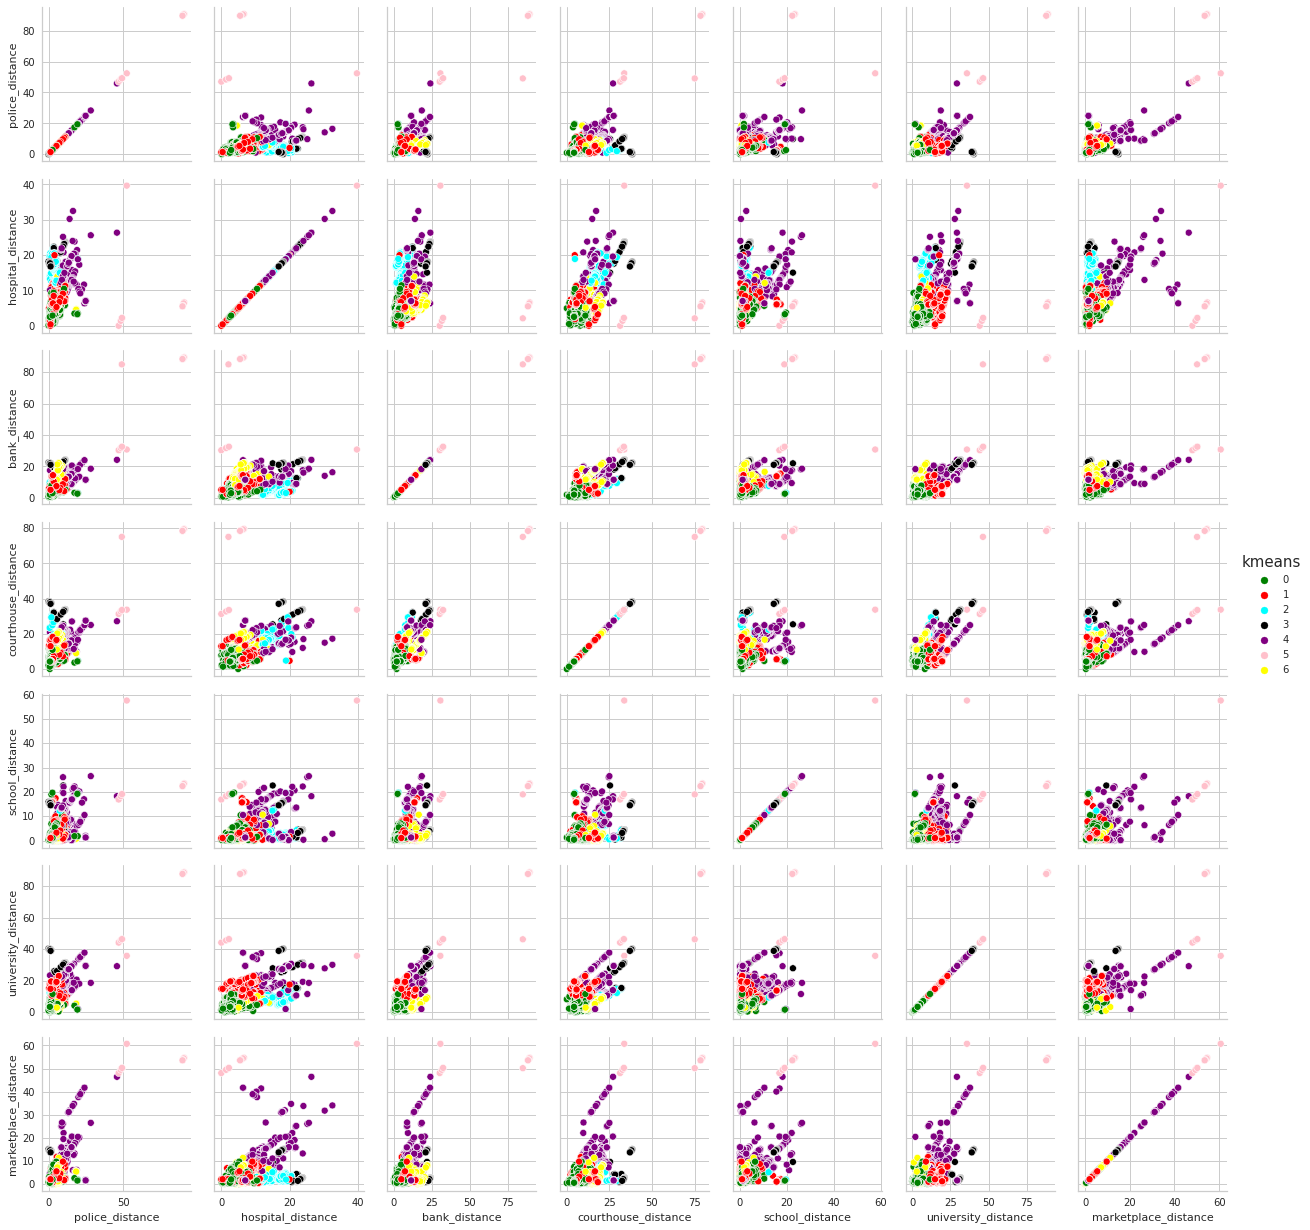

In [232]:
# ax = sns.scatterplot(data=train[cond], x='police_distance', y='hospital_distance', hue='kmeans', 
#                 palette=['green','orange','brown','dodgerblue','red','cyan'])
# palette = [cmap(0), cmap(1), cmap(2), cmap(3), cmap(4), cmap(5)]
g = sns.PairGrid(train[cond], hue='kmeans',  
                 palette = ['green','red','cyan','black','purple','pink','yellow'])
g.map(sns.scatterplot)
g.add_legend()

# Hierarchical Clustering

In [292]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# iris = load_iris()
# X = iris.data
features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# X_scaled = MinMaxScaler().fit_transform(train)
X = train

# setting distance_threshold=0 ensures we compute the full tree.
# model = AgglomerativeClustering(n_clusters=7)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode='level', p=10)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.tight_layout()
# plt.show()

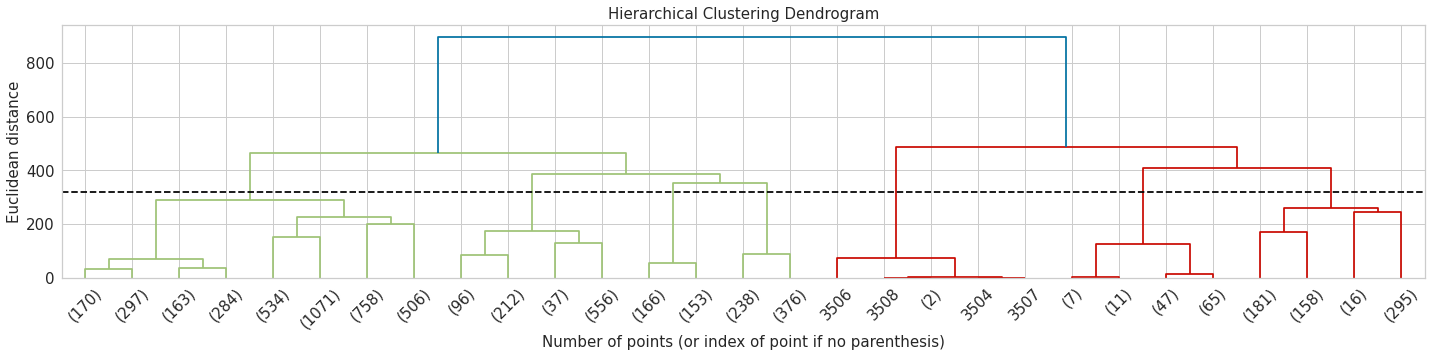

CPU times: user 575 ms, sys: 209 ms, total: 784 ms
Wall time: 418 ms


In [318]:
%%time
fig, ax = plt.subplots(figsize=(20,5))
plot_dendrogram(model, truncate_mode='level', p=4, ax=ax)
plt.title('Hierarchical Clustering Dendrogram', fontsize=15)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).", fontsize=15)
plt.xlabel("Number of points (or index of point if no parenthesis)", fontsize=15)

plt.ylabel("Euclidean distance", fontsize=15)

plt.tight_layout()
# ax.set_xlabel(size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax.hlines(y=320, xmin=0, xmax=1000, linestyles='--', color='black')

plt.show()

In [316]:
hcModel = AgglomerativeClustering(n_clusters=7)
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
hcModel = hcModel.fit(X)

matrix['hc'] = hcModel.labels_

# plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=model.labels_, cmap=plt.cm.nipy_spectral)

In [562]:
matrix['hc_label'] = matrix.apply(lambda x : 'H' + str(int(x['hc'])), axis=1 )
matrix['hc_label'].replace({'H0':'H0', 
                         'H1':'H4', 
                         'H2': 'H1', 
                         'H3': 'H2',
                        'H4':'H3',
                        'H5':'H5',
                        'H6':'H6'}, inplace=True)

matrix.head()

,police_distance,hospital_distance,bank_distance,casino_distance,courthouse_distance,school_distance,university_distance,marketplace_distance,kmeans,hc,optics,kmeans_label,hc_label
osmid,,,,,,,,,,,,,
914290204,2.476109,3.589257,7.518962,12.074351,7.612450,0.698371,3.778315,2.416770,0,0,-1,K0,H0
1572591430,3.856053,1.960662,5.890367,10.445756,7.204732,0.496094,4.645025,3.728522,0,0,-1,K0,H0
1757617874,3.326836,3.431502,7.361207,11.916596,8.463177,1.549098,4.629042,3.267497,0,0,-1,K0,H0
2886418954,4.496008,4.693962,8.623667,13.179056,9.938032,1.413258,7.378325,4.285310,0,0,-1,K0,H0
3718988215,5.109873,4.080097,8.009802,12.565191,9.324167,2.027123,6.764460,4.899175,0,0,-1,K0,H0


CPU times: user 2.36 s, sys: 149 ms, total: 2.51 s
Wall time: 2.43 s


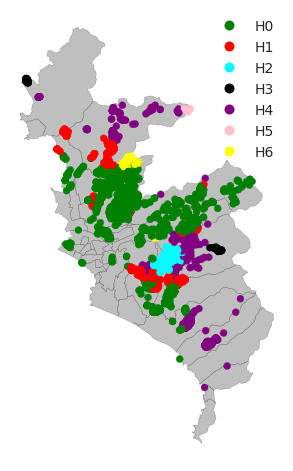

In [576]:
%%time
#Ploting k-Means clustering
# import matplotlib as mpl

fig, ax = plt.subplots(figsize = (5,10))
tmp = limanodes.join(matrix['hc_label'])
cond = ~tmp['hc_label'].isna()
# tmp

limaMapa[limaMapa.provincia=='LIMA'].plot(ax=ax, color='gray', edgecolor='k', alpha=.5)

cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','yellow'])

# colors = pl.cm.jet(np.linspace(0,1,6))
# tmp['hc_label'].replace({'H0':'H0', 
#                          'H1':'H4', 
#                          'H2': 'H1', 
#                          'H3': 'H2',
#                         'H4':'H3',
#                         'H5':'H5',
#                         'H6':'H6'}, inplace=True)

tmp[cond].plot(column='hc_label', ax=ax, legend=True, cmap=cmap, categorical=True,
#                colors=['green','orange','brown','dodgerblue','red','cyan']
               legend_kwds = {'fontsize':14}
              )
# plt.colorbar(ticks=range(6), label='k-means')
_ = plt.axis(False)

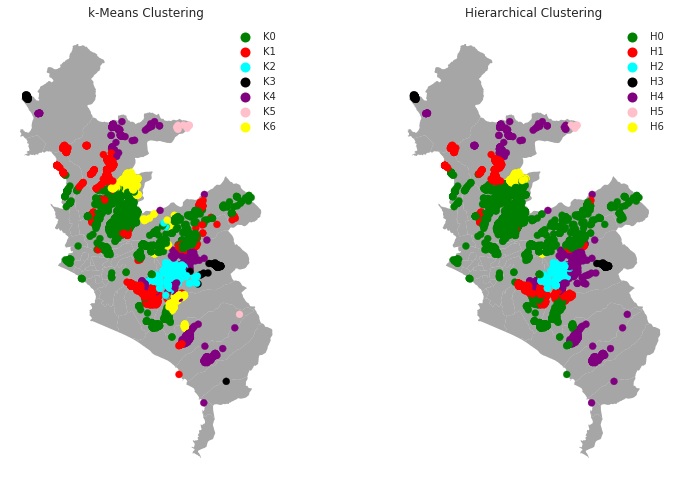

In [491]:
plt.figure(figsize=(12, 7))
G = gridspec.GridSpec(1, 2)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])

##################################
tmp = limanodes.join(matrix['kmeans_label'])
cond = ~tmp['kmeans_label'].isna()
# tmp
limaMapa[limaMapa.provincia=='LIMA'].plot(ax=ax1, alpha=0.7, color='gray')

cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','yellow'])
tmp[cond].plot(column='kmeans_label', ax=ax1, legend=True, cmap=cmap, categorical=True)

ax1.set_title("k-Means Clustering")
ax1.axis('off')
##################################
tmp = limanodes.join(matrix['hc_label'])
cond = ~tmp['hc_label'].isna()
# tmp
limaMapa[limaMapa.provincia=='LIMA'].plot(ax=ax2, alpha=0.7, color='gray')

cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','yellow'])
# cmap = matplotlib.colors.ListedColormap(['green','purple','red','cyan','black','pink','yellow'])

tmp['hc_label'].replace({'H0':'H0', 
                         'H1':'H4', 
                         'H2': 'H1', 
                         'H3': 'H2',
                        'H4':'H3',
                        'H5':'H5',
                        'H6':'H6'}, inplace=True)

tmp[cond].plot(column='hc_label', ax=ax2, legend=True, cmap=cmap, categorical=True)

ax2.set_title("Hierarchical Clustering")
ax2.axis('off')

##################################
plt.tight_layout()
plt.show()

In [573]:
import statistics
matrix.groupby('hc_label').agg(['count', np.mean, statistics.stdev])

police_distance                       hospital_distance             \
                   count       mean      stdev             count       mean   
hc_label                                                                      
H0                  3783   3.566255   1.768509              3783   3.809577   
H1                   901   3.964463   1.590350               901   7.915140   
H2                   614   4.236847   1.563492               614  15.253297   
H3                   130   8.939751   3.254458               130  22.107925   
H4                   650  11.676265   5.253762               650  12.061767   
H5                     6  83.387280  16.791098                 6   5.288819   
H6                   319   6.574183   1.907627               319   5.847553   

                   bank_distance                      casino_distance  ...  \
             stdev         count       mean     stdev           count  ...   
hc_label                                                               ...   
H0        2.006137          3783   5.140666  2.734824            3783  ...   
H1        2.348850           901   7.655058  3.517509             901  ...   
H2        2.546223           614   3.710424  1.328321             614  ...   
H3        1.939249           130  23.098287  0.756545             130  ...   
H4        4.035452           650  11.951118  4.296810             650  ...   
H5        1.629158             6  88.177554  1.629158               6  ...   
H6        0.956795           319  17.805772  1.360823             319  ...   

         marketplace_distance kmeans                        hc             \
                        stdev  count      mean     stdev count mean stdev   
hc_label                                                                    
H0                   1.598665   3783  0.827386  1.937569  3783    0     0   
H1                   2.412798    901  1.221976  0.969310   901    2     0   
H2                   1.481135    614  2.000000  0.000000   614    3     0   
H3                   4.372563    130  3.000000  0.000000   130    4     0   
H4                   7.322334    650  3.807692  0.662630   650    1     0   
H5                   1.629158      6  5.000000  0.000000     6    5     0   
H6                   1.499481    319  6.000000  0.000000   319    6     0   

         optics                      
          count      mean     stdev  
hc_label                             
H0         3783 -0.473962  1.331709  
H1          901  1.390677  2.719984  
H2          614  3.985342  4.305023  
H3          130  8.476923  3.813919  
H4          650  1.624615  4.398908  
H5            6 -1.000000  0.000000  
H6          319  5.605016  1.617740  

[7 rows x 33 columns]

In [548]:
tmp = matrix.groupby('kmeans_label').agg(['count', 'mean'])
tmp
tmp[tmp.columns[[0,1,3,5,7,9,11,13]]]
k = tmp[tmp.columns[[1,3,5,7,9,11,13]]].mean(axis=1)

tmp2 = matrix.groupby('hc_label').agg(['count', 'mean'])
tmp2
tmp2[tmp2.columns[[0,1,3,5,7,9,11,13]]]
h = tmp2[tmp2.columns[[1,3,5,7,9,11,13]]].mean(axis=1)

x = pd.concat([k.reset_index(), h.reset_index()], axis=1, ignore_index=True)
x

,0,1,2,3
0,K0,4.961999,H0,5.490638
1,K1,7.939728,H1,8.310431
2,K2,9.455942,H2,9.215710
3,K3,23.442398,H3,23.734139
4,K4,14.096743,H4,14.166715
5,K5,49.555409,H5,63.770292
6,K6,8.044335,H6,8.987050


In [547]:
# x['1'] = np.round(x['1'],2)
x['latex'] = x.apply(lambda r: '&'.join(r.map(str)), axis=1)
x['latex']

,0,1,2,3,latex
0,K0,4.961999,H0,5.490638,K0&4.961998825797027&H0&5.490637916921561&K0&4...
1,K1,7.939728,H1,8.310431,K1&7.9397282690552275&H1&8.310430828444591&K1&...
2,K2,9.455942,H2,9.215710,K2&9.455941766057995&H2&9.21570959306654&K2&9....
3,K3,23.442398,H3,23.734139,K3&23.44239830761209&H3&23.734139201098902&K3&...
4,K4,14.096743,H4,14.166715,K4&14.096743402575722&H4&14.16671479010989&K4&...
5,K5,49.555409,H5,63.770292,K5&49.55540936363638&H5&63.77029207142859&K5&4...
6,K6,8.044335,H6,8.987050,K6&8.0443351213575&H6&8.987049716077028&K6&8.0...


In [531]:
tmp = matrix.groupby('hc_label').agg(['count', 'mean'])
tmp
tmp[tmp.columns[[0,1,3,5,7,9,11,13]]]
tmp[tmp.columns[[1,3,5,7,9,11,13]]].mean(axis=1)

hc_label
H0     5.490638
H1     8.310431
H2     9.215710
H3    23.734139
H4    14.166715
H5    63.770292
H6     8.987050
dtype: float64

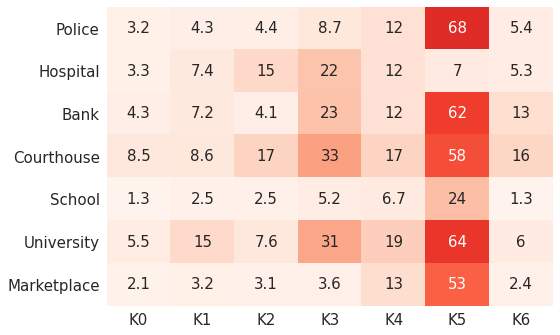

In [525]:
data = matrix.groupby('kmeans_label')[features].agg('mean')
ax = sns.heatmap(data=data.transpose(), cmap="Reds", vmin=0, vmax=100,
           yticklabels=['Police', 'Hospital', 'Bank', 'Courthouse', 'School', 'University', 'Marketplace'],
                annot=True, cbar=False, 
           )
ax.set_xlabel(None)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

<AxesSubplot:xlabel='hc_label'>

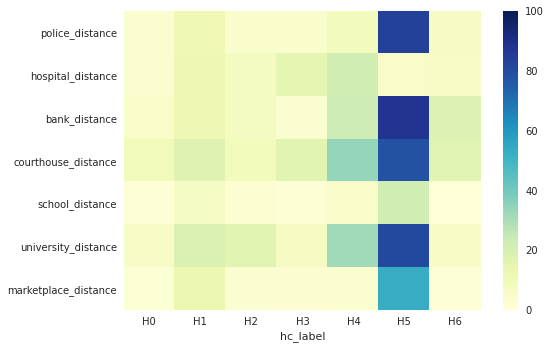

In [500]:
data = matrix.groupby('hc_label')[features].agg('mean')
sns.heatmap(data=data.transpose(), cmap="YlGnBu", vmin=0, vmax=100)

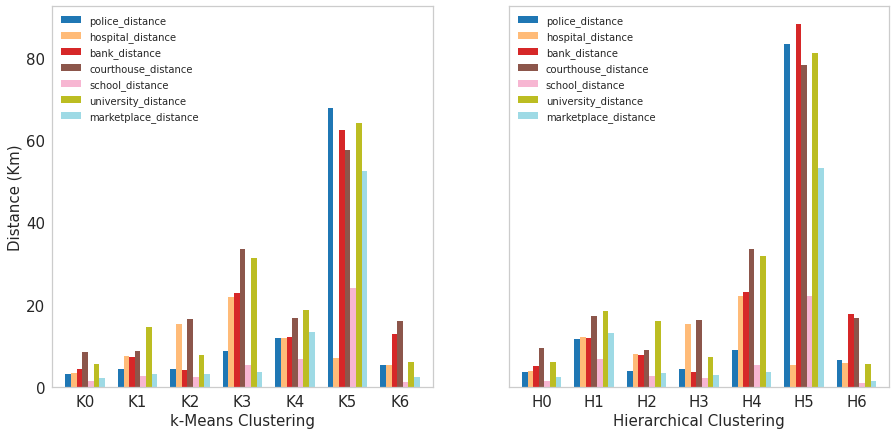

In [483]:
features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,7), sharey=True)

cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','orange'])
cmap = 'tab20'

matrix.groupby('kmeans_label')[features].agg('mean').plot(ax=ax1, kind='bar', fontsize=15, width=0.75, cmap=cmap)
matrix.groupby('hc_label')[features].agg('mean').plot(ax=ax2, kind='bar', fontsize=15, width=0.75, cmap=cmap)

ax1.set_ylabel("Distance (Km)", fontsize=15)
ax1.set_xlabel("k-Means Clustering", fontsize=15)
ax1.grid(False)
labels = ['K0','K1','K2','K3','K4','K5','K6']
ax1.set_xticklabels( labels, rotation=0)


ax2.set_xlabel("Hierarchical Clustering", fontsize=15)
ax2.grid(False)
labels = ['H0','H1','H2','H3','H4','H5','H6']
ax2.set_xticklabels( labels, rotation=0)

plt.show()

# DBSCAN

In [427]:
%%time
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# X_scaled = MinMaxScaler().fit_transform(train)

#DBSCAN
# dbscanModel = DBSCAN(eps=3)
# dbscanModel.fit(X_scaled)
# dbscanModel.labels_
X = train
opticsModel = OPTICS(min_samples=100, metric='euclidean')
opticsModel.fit(X)
matrix['optics'] = opticsModel.labels_


CPU times: user 3min 5s, sys: 4min 24s, total: 7min 30s
Wall time: 13.3 s


In [428]:
matrix.groupby('optics')[features].agg(['count','mean'])

police_distance            hospital_distance            bank_distance  \
                 count       mean             count       mean         count   
optics                                                                         
-1                4392   4.603206              4392   5.562920          4392   
 0                 153   7.169989               153   8.094610           153   
 1                 177   2.965161               177   6.014940           177   
 2                 124   2.150636               124  10.740798           124   
 3                 135   3.587437               135   3.115439           135   
 4                 185   4.392226               185   4.188996           185   
 5                 301   4.354567               301   8.177409           301   
 6                 301   6.332256               301   5.848488           301   
 7                 116   6.563054               116  13.617948           116   
 8                 237   3.864527               237  18.175731           237   
 9                 170   9.249014               170   9.343397           170   
 10                112  10.221759               112  22.853573           112   

                  courthouse_distance            school_distance            \
             mean               count       mean           count      mean   
optics                                                                       
-1       6.042726                4392  10.670071            4392  2.561906   
 0       6.054293                 153   6.422074             153  2.887553   
 1       7.228287                 177   8.485483             177  2.037444   
 2       9.561736                 124  10.900851             124  1.724840   
 3       6.905531                 135  12.456072             135  0.491106   
 4       8.290490                 185  18.688630             185  0.921210   
 5       4.326330                 301   5.206774             301  1.169817   
 6      17.625846                 301  16.617966             301  0.928458   
 7       5.478112                 116  17.270331             116  4.254140   
 8       3.223644                 237  15.478164             237  1.772985   
 9      15.218562                 170  18.688926             170  1.363371   
 10     23.316285                 112  32.984970             112  3.603654   

       university_distance            marketplace_distance             
                     count       mean                count       mean  
optics                                                                 
-1                    4392   8.598310                 4392   3.638288  
 0                     153   8.850606                  153   4.880380  
 1                     177  10.626405                  177   1.277845  
 2                     124  12.777457                  124   1.208507  
 3                     135   1.400680                  135   1.891970  
 4                     185   6.902155                  185   3.034466  
 5                     301  17.903706                  301   4.714853  
 6                     301   5.335062                  301   0.985192  
 7                     116   8.257126                  116   5.400676  
 8                     237   6.359583                  237   2.850573  
 9                     170  21.102374                  170  13.212480  
 10                    112  30.612775                  112   1.801382

(-77.22770165474994,
 -76.59192544224989,
 -12.56730783700092,
 -11.525030732977177)

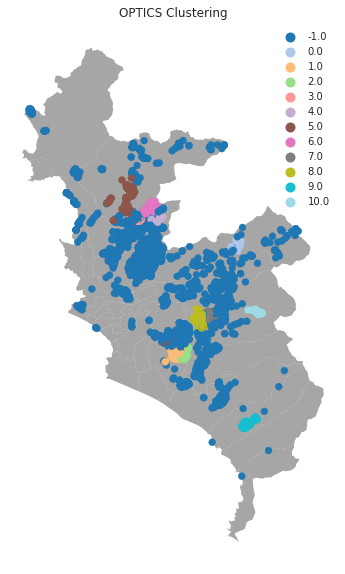

In [429]:
fig, ax = plt.subplots(figsize = (10,10))

tmp = limanodes.join(matrix['optics'])
cond = ~tmp['optics'].isna()
# tmp
limaMapa[limaMapa.provincia=='LIMA'].plot(ax=ax, alpha=0.7, color='gray')

# cmap = matplotlib.colors.ListedColormap(['green','red','cyan','black','purple','pink','yellow'])
cmap = matplotlib.colors.ListedColormap(['green','purple','red','cyan'])
cmap = 'tab20'
tmp[cond].plot(column='optics', ax=ax, legend=True, cmap=cmap, categorical=True)

ax.set_title("OPTICS Clustering")
ax.axis('off')
# plt.legend('off')

In [431]:
1500*3.8

5700.0

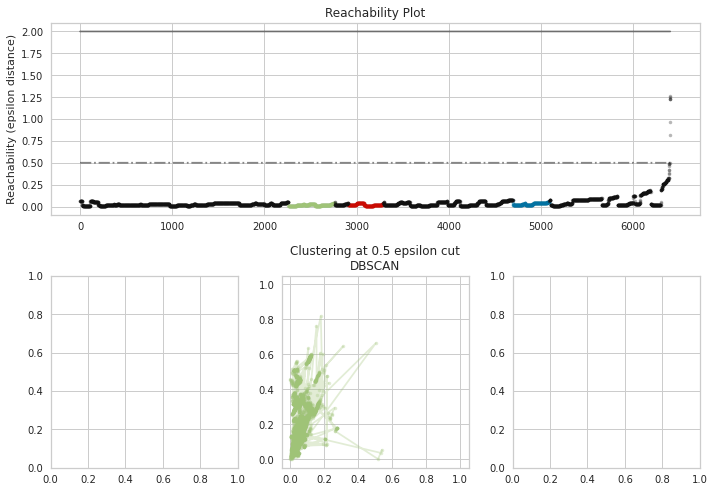

CPU times: user 9.18 s, sys: 167 ms, total: 9.34 s
Wall time: 9.1 s


In [106]:
%%time
from sklearn.cluster import DBSCAN, OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

features = ['police_distance', 
            'hospital_distance', 
            'bank_distance', 
#             'casino_distance',
            'courthouse_distance', 
            'school_distance',
            'university_distance', 
            'marketplace_distance']
train = matrix[features]
# X_scaled = MinMaxScaler().fit_transform(train)

#DBSCAN
# dbscanModel = DBSCAN(eps=3)
# dbscanModel.fit(X_scaled)
# dbscanModel.labels_
X = X_scaled
clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)
clust.fit(X)
# opticsModel.labels_


labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')


# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()